# Step 1

## a. Define each of the 5 factors in the Fama-French 5 model

## b. For each factor, explain how it helps to explain returns

# Step 2

Download daily data from [this site](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) for a timeframe of 3 years

Below, we include all Python package that will be used.

In [39]:
from datetime import datetime, date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

plt.rcParams["figure.figsize"] = (16, 9)

## a. Import, structure, and graph the daily factor returns

We begin by importing the ``csv`` file into a ``pandas DataFrame``.

We set our timeframe of observation on the 3-year period that goes from March 1st, 2021 to February 29th, 2024.

In [15]:
# csv to pd.DataFrame
path = "F-F_Research_Data_5_Factors_2x3_daily.csv" # relative path of csv file
df_daily = pd.read_csv(path, header=2, date_format='%Y%m%d', parse_dates=True)#, skipfooter=0, engine="python")

# adapt 1st column to date format in python
df_daily['Unnamed: 0'] = df_daily['Unnamed: 0'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
df_daily = df_daily.rename(columns={'Unnamed: 0': 'Date'})
df_daily = df_daily.set_index('Date')

# 3-year timeframe chosen
start = date(2021, 3, 1)
end = date(2024, 2, 29)
df_daily = df_daily[start: end]

df_daily

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2021-03-01,2.63,1.11,0.23,-0.41,0.23,0.000
2021-03-02,-1.05,-0.77,1.23,0.62,0.20,0.000
2021-03-03,-1.57,0.64,3.56,1.67,1.05,0.000
2021-03-04,-1.70,-1.11,1.71,1.29,0.44,0.000
2021-03-05,1.85,0.36,0.61,0.97,0.51,0.000
...,...,...,...,...,...,...
2024-02-23,0.02,0.32,-0.03,0.09,-0.11,0.021
2024-02-26,-0.26,0.97,-0.11,-0.74,-0.01,0.021
2024-02-27,0.27,1.24,-0.45,-1.14,0.67,0.021


The time series for each of the Fama-French (FF) factors in the timeframe considered are visualised below.

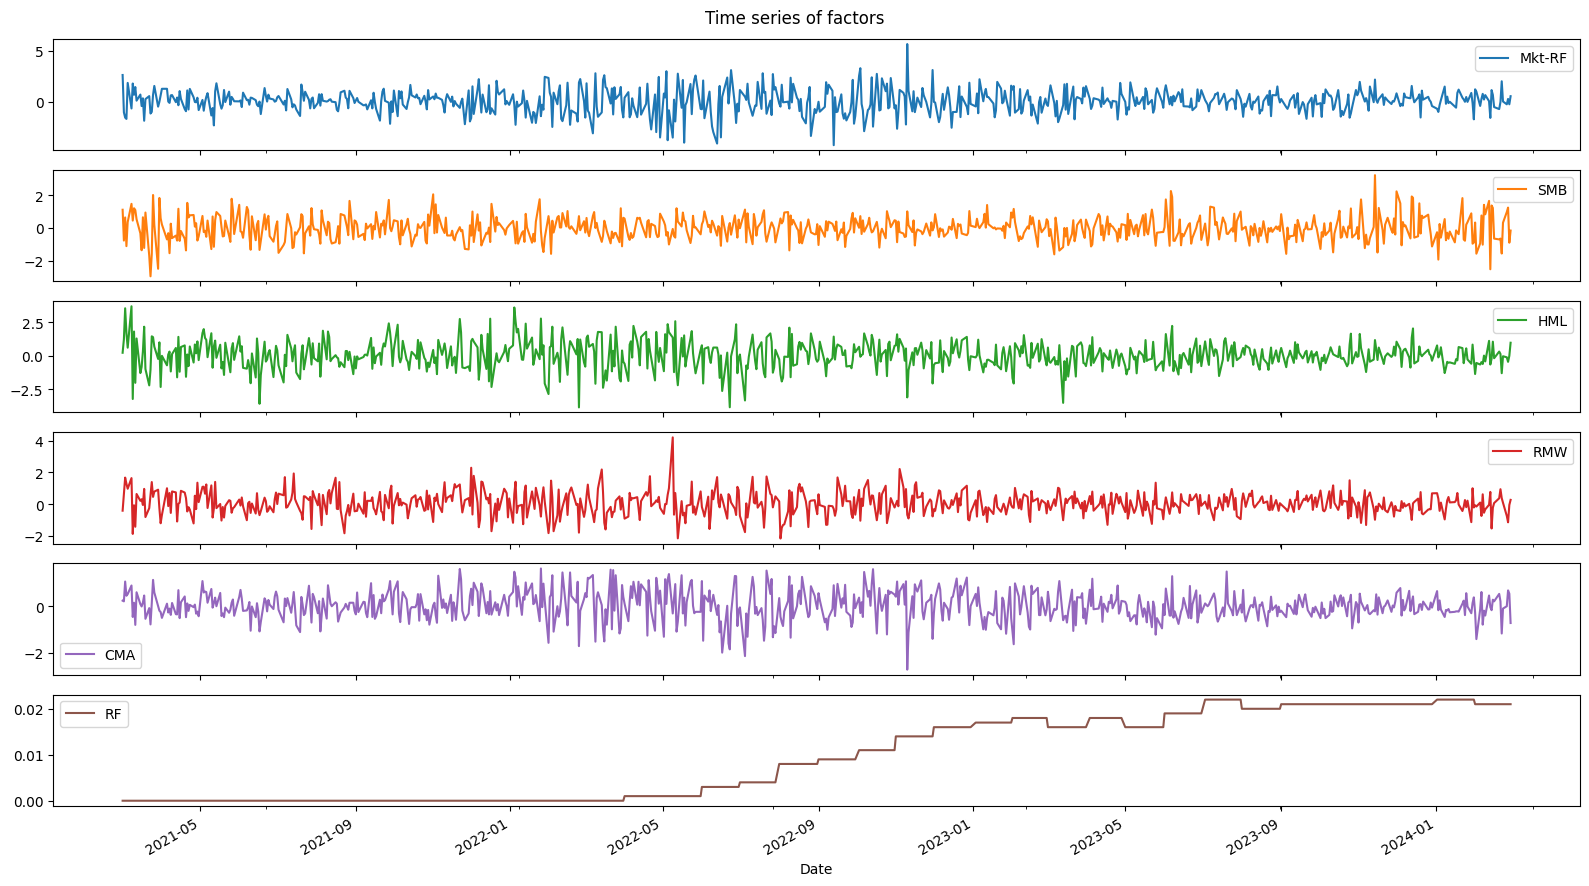

In [61]:
# graph time series of factors
df_daily.plot(subplots=True, title="Time series of factors")
plt.tight_layout()
plt.show()

Some additional statistics regarding the time series of the 5 FF factors:

In [17]:
df_daily.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,0.031442,-0.028810,0.029418,0.044471,0.017500,0.009373
std,1.155105,0.721922,1.037161,0.712109,0.619492,0.008988
min,-4.290000,-2.950000,-3.860000,-2.160000,-2.730000,0.000000
25%,-0.652500,-0.500000,-0.580000,-0.380000,-0.352500,0.000000
50%,0.025000,-0.020000,-0.010000,0.040000,0.000000,0.008000
75%,0.710000,0.410000,0.672500,0.510000,0.400000,0.018000
max,5.680000,3.220000,3.710000,4.200000,1.610000,0.022000


## b. Collect and compute correlations of the changes in the factor returns.

As a preliminary to the analysis of their returns, we inspect the daily correlations of the five factors themselves:

In [63]:
df_daily_corr = df_daily.corr()
df_daily_corr

,Mkt-RF,SMB,HML,RMW,CMA,RF
Mkt-RF,1.000000,0.243415,-0.362545,-0.352044,-0.467402,0.026337
SMB,0.243415,1.000000,0.104209,-0.430382,-0.040453,0.003073
HML,-0.362545,0.104209,1.000000,0.434571,0.754853,-0.050252
RMW,-0.352044,-0.430382,0.434571,1.000000,0.389006,-0.044283
CMA,-0.467402,-0.040453,0.754853,0.389006,1.000000,-0.080202
RF,0.026337,0.003073,-0.050252,-0.044283,-0.080202,1.000000


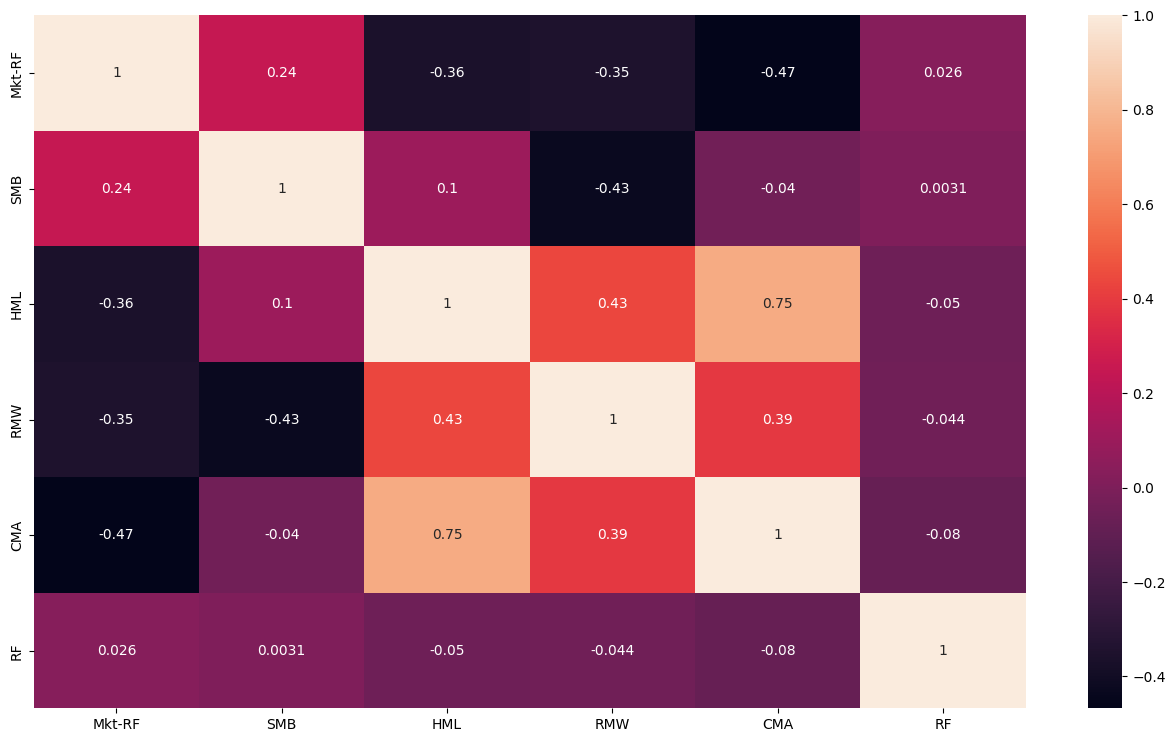

In [64]:
sns.heatmap(df_daily_corr, annot=True)
plt.show()

From the above we can see that almost all of the factors, with the exception of the risk free rate RF, are heavily correlated, either positively or negatively.

The daily factor returns, expressed as percent change with respect to the previous day, are derived as:

In [65]:
factor_returns = df_daily.pct_change()
# drop nan values from 1st line, and set 0/0 divisions to 0.0
factor_returns = factor_returns.drop(start)
factor_returns = factor_returns.where(factor_returns.notna(), 0.0)

factor_returns

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2021-03-02,-1.399240,-1.693694,4.347826,-2.512195,-0.130435,0.0
2021-03-03,0.495238,-1.831169,1.894309,1.693548,4.250000,0.0
2021-03-04,0.082803,-2.734375,-0.519663,-0.227545,-0.580952,0.0
2021-03-05,-2.088235,-1.324324,-0.643275,-0.248062,0.159091,0.0
2021-03-08,-1.362162,3.083333,5.081967,0.690722,0.725490,0.0
...,...,...,...,...,...,...
2024-02-23,-0.990050,-1.205128,-0.976923,-0.763158,-0.906780,0.0
2024-02-26,-14.000000,2.031250,2.666667,-9.222222,-0.909091,0.0
2024-02-27,-2.038462,0.278351,3.090909,0.540541,-68.000000,0.0


Above, 

- we dropped `NaN` values stemming from the first line (that lacks previous reference data) of the DataFrame, and 
- we replaced $\frac{0}{0} = \text{NaN}$, mainly appearing in the RF column when both previous and current daily entries are $= 0$, with $0$.

Plotting the time series of returns yields:

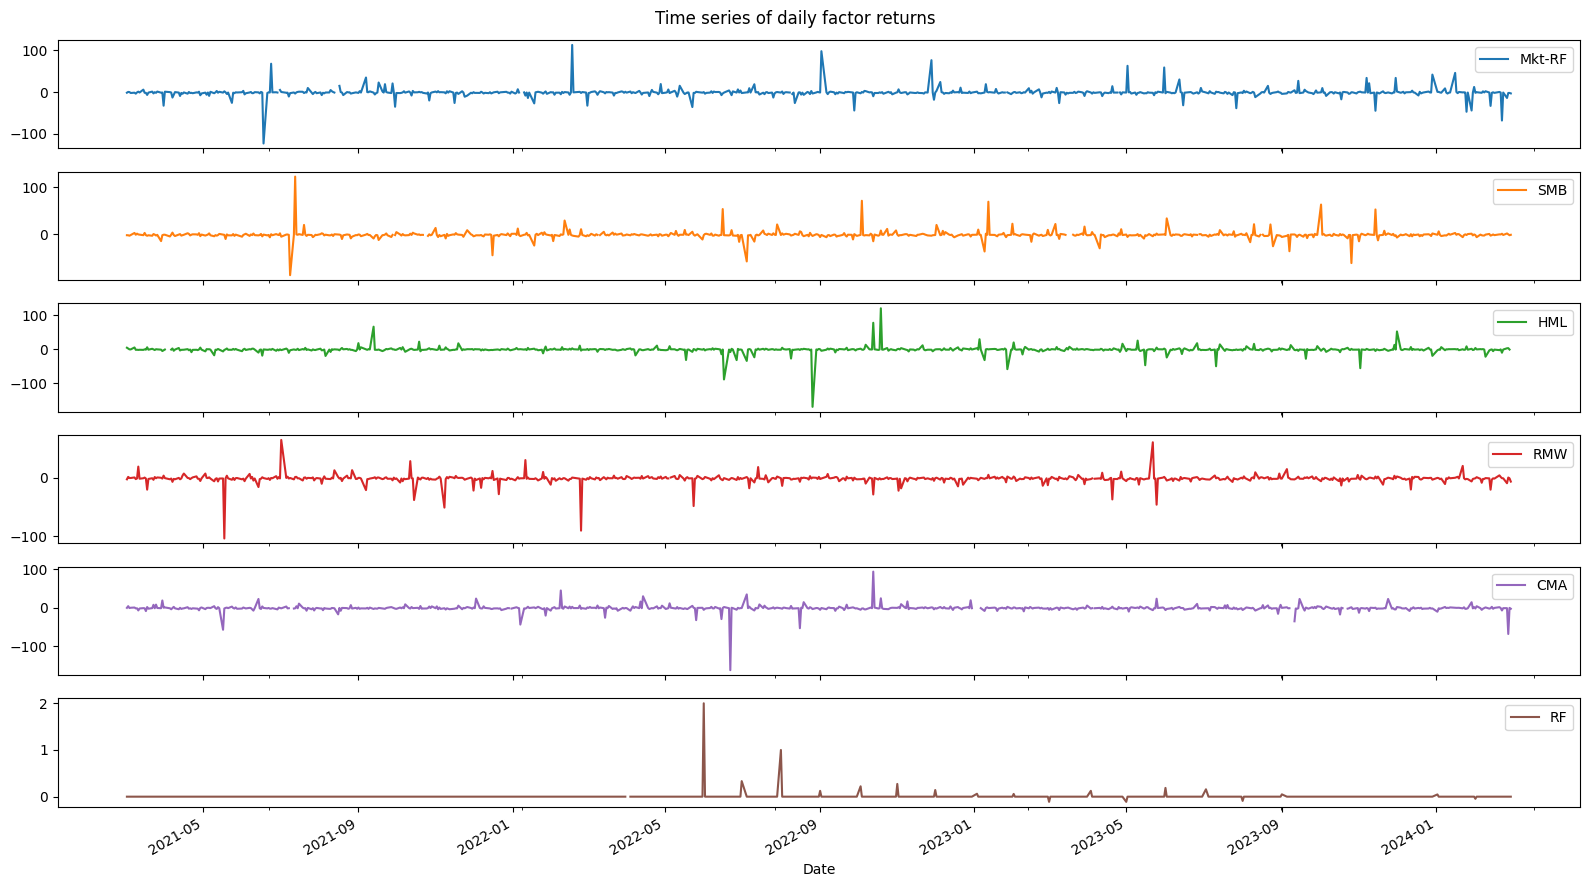

In [66]:
factor_returns.plot(subplots=True, title="Time series of daily factor returns")
plt.tight_layout()
plt.show()

At first glance, the series look fairly stationary.

One can however observe imperfections in most of the graphs, in the form of gaps within plottings (for instance, in the plot for RF at about 2022-04).
These are $- \infty$ or $\infty$ values in the time series originated from dividing from a previous daily value of $0$.
We correct this by setting infinity values to an arbitrarily large number, $\pm 1000$.

In [67]:
# set infinity points to + or - 1000
factor_returns = factor_returns.where(factor_returns != np.inf, 1000.0)
factor_returns = factor_returns.where(factor_returns != -np.inf, -1000.0)

Now we can finally compute the correlation matrix between the five factor returns.

In [68]:
factor_corr = factor_returns.corr()
factor_corr

,Mkt-RF,SMB,HML,RMW,CMA,RF
Mkt-RF,1.000000,-0.002249,0.005137,-0.000859,0.009779,0.000929
SMB,-0.002249,1.000000,-0.002190,-0.001015,-0.011633,0.000715
HML,0.005137,-0.002190,1.000000,0.001019,0.015205,0.001103
RMW,-0.000859,-0.001015,0.001019,1.000000,0.261718,0.001419
CMA,0.009779,-0.011633,0.015205,0.261718,1.000000,-0.002398
RF,0.000929,0.000715,0.001103,0.001419,-0.002398,1.000000


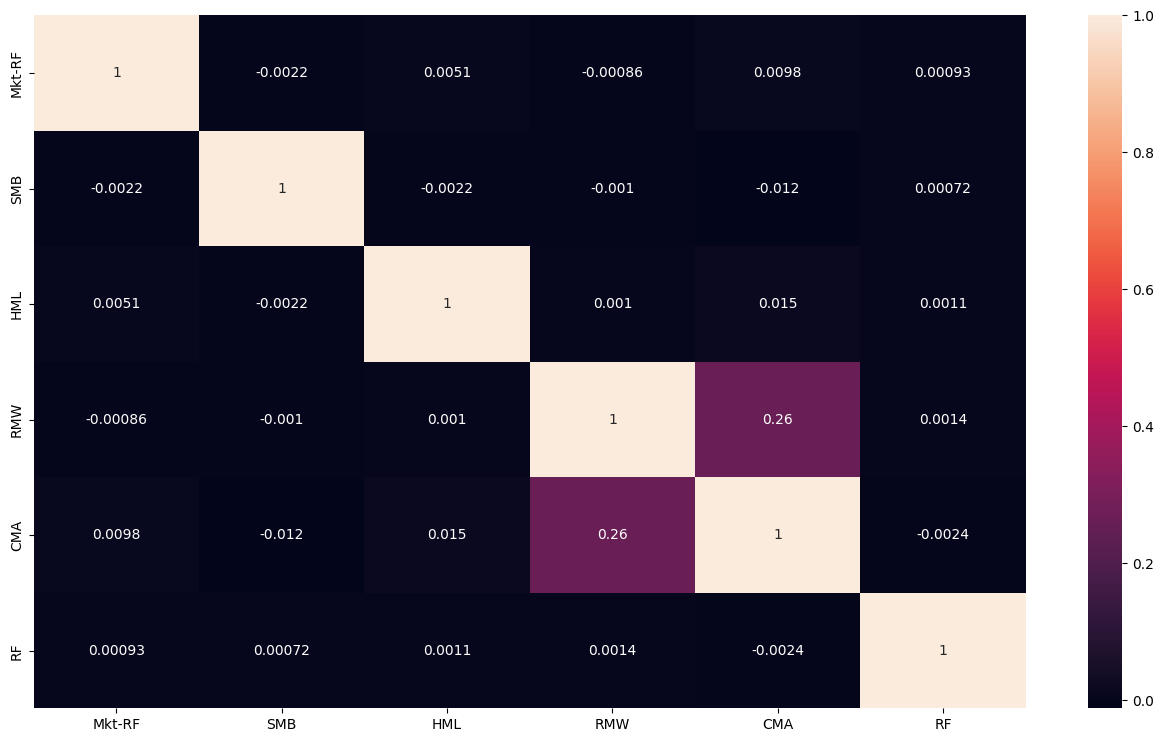

In [38]:
sns.heatmap(factor_corr, annot=True)
plt.show()

The series of factor returns are uncorrelated, with just one exception of weak correlation between RMW and CMA.

## c. Collect economic data of your choice during that 3-year period

As a proxy for risk-free rate, we download from *Yahoo! Finance* data tracking the ^IRX index, which is based on yields from the 13-week US Treasury bills.

In [57]:
tbill_13w = yf.download("^IRX", start, end)
tbill_13w = pd.DataFrame(tbill_13w["Adj Close"])
tbill_13w = tbill_13w.rename(columns={'Adj Close': '^IRX'})
tbill_13w

[*********************100%%**********************]  1 of 1 completed


,^IRX
Date,
2021-03-01,0.028
2021-03-02,0.035
2021-03-03,0.035
2021-03-04,0.028
2021-03-05,0.028
...,...
2024-02-22,5.233
2024-02-23,5.240
2024-02-26,5.250


As could be expected, the graph below shows that this interest rates index increases in value following worldwide inflation due to 
- disruptions in global production and supply of goods and services after the Covid pandemic, and 
- sanctions to Russia which increased costs for raw materials.

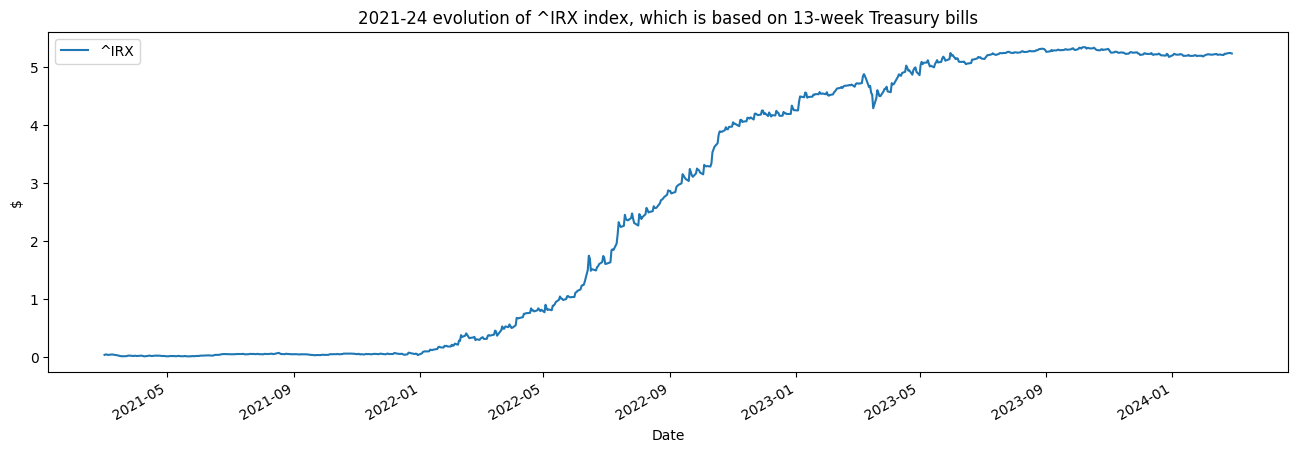

In [60]:
title = "2021-24 evolution of ^IRX index, which is based on 13-week Treasury bills"
tbill_13w.plot(figsize=(16, 5), title=title, ylabel="$")
plt.legend()
plt.show()

# Step 3

Find the betas of factors in the Fama-French 3 model.

## a. Run both Least Squares and robust regressions on the data, and describe the train-test split.

## b. Provide summaries of coefficients and metrics for the model